In [1]:
# load packages
%matplotlib inline
%cd ..
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore

from open_ephys.analysis import Session
from pathlib import Path
import glob


%matplotlib widget
import spikeinterface as si
import xarray as xr
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from aind_ephys_utils import align 
import myFunctions
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re

/root/capsule/code


In [2]:
# load nwb and curation
curationName = 'ZhixiaoSu'
sessionID = '716325_2024-05-29_10-33-32'
data_dir = "/root/capsule/data/"

nwb_folder = f"{data_dir}{sessionID}_experiment1_recording1"
nwb_file = f"{sessionID}_experiment1_recording1.nwb"

io = NWBHDF5IO(nwb_folder + '/' + nwb_file, mode='r')
nwb = io.read()

units = nwb.units.to_dataframe()
unitIDs = units['ks_unit_id'].astype(int)

# load ephys recordings
directory = Path(f"{data_dir}behavior_{sessionID}")

session = Session(directory / 'ecephys_clipped')
recording = session.recordnodes[0].recordings[0]

In [3]:
# load manual curation
data_folder = Path("/data")
manualCuration_dir = [
    p for p in data_folder.iterdir() if p.is_dir() and "sorted" not in p.name and "spikesorted" not in p.name and sessionID in p.name and "curated" in p.name
]
manualCuration_dir = manualCuration_dir[0]

curation_opto_jsons = []
curation_jsons = []
for root, dirs, files in os.walk(manualCuration_dir):
    if len(curation_jsons)>0:
        break
    for file in files:
        if len(curation_jsons)>0:
            break
        if file.startswith("curation") and file.endswith(f"opto.json"):
            curation_opto_jsons.append(os.path.join(root, file))
        if file.startswith("curation.json"):
            curation_jsons.append(os.path.join(root, file))

if len(curation_opto_jsons) == 0:
    curation_json = curation_jsons[0]
else:
    curation_json = curation_opto_jsons[0]

print(curation_json)


/data/behavior_716325_2024-05-29_10-33-32_curated_2024-06-05_21-28-54/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1/kilosort2_5/curation.json


In [4]:
#%% read manual curation results.
sortingview_curation_dict = json.load(open(curation_json))
# set default to false
merge = np.array([False]*len(unitIDs))
if 'mergeGroups' in sortingview_curation_dict.keys():
    merge_groups = sortingview_curation_dict["mergeGroups"]
    # get units in merge groups
    merge_units = [unit for merge_group in merge_groups for unit in merge_group]
    merge_units = np.sort(np.unique(merge_units))
    mergeInds = [index for index, value in enumerate(unitIDs) if value in merge_units]
    merge[np.array(mergeInds)] = True
# SUA units
SUAunits = [key for key, value in sortingview_curation_dict["labelsByUnit"].items() if ('SUA' in value)|('accept' in value)]
SUAunits = np.array(SUAunits).astype(int)
SUAInds = [index for index, value in enumerate(unitIDs) if value in SUAunits]
SUA = np.array([False]*len(unitIDs))
SUA[np.array(SUAInds)] = True
# MUA, noise and reject
noiseUnits = [key for key, value in sortingview_curation_dict["labelsByUnit"].items() if ('MUA' in value)|('noise' in value)|('artifact' in value)|('reject' in value)]
noiseUnits = np.array(noiseUnits).astype(int)
noiseInds = [index for index, value in enumerate(unitIDs) if value in noiseUnits]
noise = np.array([False]*len(unitIDs))
noise[np.array(noiseInds)] = True
artifact = np.array([False]*len(noise))
# load artifact
# artifactPath = Path(f"{data_dir}artifactFilter/{sessionID}_artifact.npy")
# artifact = np.load(artifactPath)

In [6]:
# combine manual curation and artifact
units['merge'] = merge
units['SUA'] = SUA
units['noise'] = noise
units['artifact'] = artifact
# isiRatio = units['isi_violations_count']/units['num_spikes']
# units['isi_violations_ratio'] = isiRatio
qc = units[['presence_ratio', 'drift_std', 'isi_violations_ratio','l_ratio', 'amplitude', 'default_qc', 'firing_rate','merge', 'SUA', 'noise', 'artifact']].copy()
manual = (qc['default_qc'] == 'True') & (~qc['noise'])|(qc['default_qc'] == 'False') & (qc['SUA'] & (~qc['artifact']))
qcPass = (qc["presence_ratio"]>0.9) & (qc["isi_violations_ratio"]<0.1) & (qc['firing_rate']>0.2) & (manual)
print(f"{np.sum(qcPass)} out of {len(unitIDs)} pass qc")

39 out of 358 pass qc


In [7]:
tblTrials

,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,...,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,
0,3.720261e+06,3.720272e+06,2.0,False,False,3.720268e+06,3.720270e+06,3.720271e+06,True,False,...,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.5,12218.5,6652.5,2.0,2.0
1,3.720272e+06,3.720279e+06,2.0,False,False,3.720276e+06,3.720277e+06,3.720278e+06,True,False,...,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.0,12218.5,6652.0,2.0,2.0
2,3.720279e+06,3.720313e+06,0.0,False,False,3.720282e+06,3.720312e+06,3.720312e+06,False,True,...,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.0,12218.5,6652.0,2.0,2.0
3,3.720314e+06,3.720322e+06,0.0,True,False,3.720316e+06,3.720320e+06,3.720321e+06,True,False,...,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.5,12218.5,6652.0,2.0,2.0
4,3.720322e+06,3.720330e+06,0.0,True,False,3.720328e+06,3.720329e+06,3.720329e+06,True,True,...,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.5,12219.0,6652.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,3.724004e+06,3.724014e+06,2.0,False,False,3.724010e+06,3.724011e+06,3.724013e+06,True,False,...,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.0,12218.0,6652.0,2.0,2.0
431,3.724014e+06,3.724020e+06,2.0,False,False,3.724016e+06,3.724017e+06,3.724019e+06,True,False,...,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.0,12218.5,6652.0,2.0,2.0
432,3.724020e+06,3.724031e+06,2.0,False,False,3.724028e+06,3.724028e+06,3.724030e+06,False,True,...,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6756.5,12218.0,6652.0,2.0,2.0


In [8]:
np.sum(qc['default_qc'] == 'True')

118

In [6]:
# load behavior
tblTrials = nwb.trials.to_dataframe()
# load units
timestampsRS = [nwb.units[unitInd, 'spike_times'] for unitInd in range(len(unitIDs))]
print(f"In total {len(timestampsRS)} units")

In total 358 units


In [10]:
# prepare for rescaling
# extract harp clock

nidaq_node_id = 106
harp_clock = recording.events[(recording.events.processor_id == nidaq_node_id) &
                 (recording.events.line == 4)]

# find start of each barcode

splits = np.where(np.diff(harp_clock.timestamp) > 0.5)[0]
print(f'Total number of barcodes: {len(splits)}')

splits = np.where(np.diff(harp_clock.timestamp) > 0.5)[0]
first_barcode_ts = harp_clock.iloc[splits[0]+1:splits[1]+1].iloc[0].timestamp
last_barcode_ts = harp_clock.iloc[splits[1400]+1:splits[1401]+1].iloc[0].timestamp
sample_numbers, states = myFunctions.get_barcode(harp_clock, 0)
first_barcode_harp_time = myFunctions.convert_barcode_to_time(sample_numbers, states)
sample_numbers, states = myFunctions.get_barcode(harp_clock, 1400)
last_barcode_harp_time = myFunctions.convert_barcode_to_time(sample_numbers, states)
print(f'Total seconds on Harp clock: {last_barcode_harp_time - first_barcode_harp_time}')
print(f'Total seconds on Open Ephys clock: {last_barcode_ts - first_barcode_ts}')


# rescale all neurons

# spikeFolder = Path('/root/capsule/results/units')
# if not Path.exists(spikeFolder):
#     print('not exist')
#     os.mkdir(spikeFolder)

for i in range(len(nwb.units)):
    timestamps = nwb.units[i, 'spike_times']
    timestampsRS[i] = myFunctions.rescale_times(timestamps, 
                          first_barcode_harp_time, 
                          last_barcode_harp_time,
                          first_barcode_ts,
                          last_barcode_ts)
    currTs = timestampsRS[i]
    # np.save(f'{spikeFolder}/unit_{unitIDs[i]}.npy', np.array(currTs))
    
print(f'Rescaled total of {len(units)} neurons')

NameError: name 'recording' is not defined

In [9]:
trialTbl = myFunctions.makeSessionDF(nwb)
trialTbl

,outcomes,choices,laser,outcomePrev,laserPrev,choicesPrev
0,0.0,0.0,0.0,NaN,NaN,NaN
1,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,0.0,0.0
4,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
366,1.0,0.0,1.0,1.0,0.0,0.0
367,1.0,0.0,0.0,1.0,1.0,0.0
368,1.0,0.0,0.0,1.0,0.0,0.0
369,1.0,0.0,0.0,1.0,0.0,0.0


In [11]:
# metadata
nwb.scratch['metadata']
# go cue: 100ms
# laser time: when licked: choice time + 100ms = reward time
# no choice: 1.5s after go cue


,box,session_end_time,session_run_time_in_min,water_in_session_foraging,water_in_session_manual,water_in_session_total,water_after_session,water_day_total,base_weight,target_weight,target_weight_ratio,weight_after,foraging_efficiency,foraging_efficiency_with_actual_random_seed,laser_1_calibration_power,laser_2_calibration_power,laser_1_target_areas,laser_2_target_areas,commit_ID,repo_url,current_branch
id,,,,,,,,,,,,,,,,,,,,,
0,Tower_EphysRig3,2024-02-14 12:35:26.082655,59,0.57,NaN,NaN,NaN,0.603,28.53,24.25,0.85,NaN,0.629765,0.666667,NaN,NaN,None,None,None,None,None


In [8]:
# plot and save all units with append method
sessionFolder = Path(f'/root/capsule/results/{sessionID}')
if not Path.exists(sessionFolder):
    print('Creating sessionFolder')
    os.mkdir(sessionFolder)
    
appendFolder = Path(f'{sessionFolder}/append')
if not Path.exists(appendFolder):
    print('Creating appendFolder')
    os.mkdir(appendFolder)

# plot and save
xarrayFolder = Path(f"{sessionFolder}/xarray")
if not Path.exists(xarrayFolder):
    print('Creating xarrayFolder')
    os.mkdir(xarrayFolder)

In [9]:
def merge_pdfs(input_dir, output_filename='merged.pdf'):
    merger = PdfMerger()

    # Iterate through all PDF files in the input directory
    for i, filename in enumerate(os.listdir(input_dir)):
        if filename.endswith('.pdf'):
            if i%50 == 0:
                print(f'Merging file {i} out of {len(os.listdir(input_dir))}')
            filepath = os.path.join(input_dir, filename)
            merger.append(filepath)

    # Write the merged PDF to the output file
    with open(output_filename, 'wb') as output_file:
        merger.write(output_file)

    print(f"PDF files in '{input_dir}' merged into '{output_filename}' successfully.")

In [19]:
# # load model vars
# modelPath = f'{data_dir}/models'
# modelFile = f'{modelPath}/{sessionID}_5paramsMLE.mat'
# fitRL = loadmat(modelFile)
# Q = fitRL['modelVars']['Q'][0][0][:,:]
# Qsum = np.sum(Q, axis=1)
# Qdiff = Q[:,1] - Q[:,0]
# prepare behavior
trialTbl = myFunctions.makeSessionDF(nwb)
tblTrials = nwb.trials.to_dataframe()
trialStarts = tblTrials.loc[tblTrials['animal_response']!=2, 'goCue_start_time'].values
responseTimes = tblTrials[tblTrials['animal_response']!=2]
responseTimes = responseTimes['reward_outcome_time'].values

# responseInds
responseInds = tblTrials['animal_response']!=2
leftRewards = tblTrials.loc[responseInds, 'rewarded_historyL']

# oucome 
leftRewards = tblTrials.loc[tblTrials['animal_response']!=2, 'rewarded_historyL']
rightRewards = tblTrials.loc[tblTrials['animal_response']!=2, 'rewarded_historyR']
outcomes = leftRewards | rightRewards
outcomePrev = np.concatenate((np.full((1), np.nan), outcomes[:-1]))

# choices
choices = tblTrials.loc[tblTrials['animal_response']!=2, 'animal_response'] == 1
choicesPrev = np.concatenate((np.full((1), np.nan), choices[:-1]))
# laser
laserChoice = tblTrials.loc[tblTrials['animal_response']!=2, 'laser_on_trial'] == 1
laser = tblTrials['laser_on_trial'] == 1
laserPrev = np.concatenate((np.full((1), np.nan), laserChoice[:-1]))
trialData = pd.DataFrame({
    'outcomes': outcomes.values.astype(float), 
    'choices': choices.values.astype(float),
    'laser': laserChoice.values.astype(float),
    'outcomePrev': outcomePrev,
    'laserPrev': laserPrev,
    'choicesPrev': choicesPrev,
    'Qsum': Qsum,
    'Qdiff': Qdiff,
    'Qr': Q[:,1],
    'Ql': Q[:,0]
    })

# make xarray

binSize = 0.2 # in second
stepSize = 0.05 # in second
bin_edges = np.arange(-2, 3, stepSize)
bin_edges = np.array(bin_edges)
time_domain_callback = None
alignTime = responseTimes

# for psth
domain = myFunctions.build_time_window_domain(
    bin_edges,
    alignTime,
    callback=time_domain_callback)
dtype = None

ends = domain[:, -1]
starts = domain[:, 0]
time_diffs = starts[1:] - ends[:-1]
overlapping = np.where(time_diffs < 0)[0]

time, counts = myFunctions.build_spike_histogram_overlap(
    domain,
    binSize,
    timestampsRS,
)
time = time[0,:]
time = bin_edges[:-1] + 0.5*binSize
tiled_data = 1/binSize * counts

trialInds = np.array(range(len(alignTime)))

spike_toResponse = xr.DataArray(
    name='spike_counts',
    data=tiled_data,
    dims=['trialInd',
          'trialTime',
          'unit_id'],
    coords={
        'trialInd': trialInds,
        'trialTime': time,
        'unit_id': np.array(range(len(timestampsRS)))
    }
)

# for LM
binSizeLM = 0.5
stepSizeLM = 0.2
bin_edgesLM = np.arange(-2, 3, stepSizeLM)

domain = myFunctions.build_time_window_domain(
    bin_edgesLM,
    alignTime,
    callback=time_domain_callback)
dtype = None

timeLM, countsLM = myFunctions.build_spike_histogram_overlap(
    domain,
    binSizeLM,
    timestampsRS,
)
timeLM = bin_edgesLM[:-1] + 0.5*binSizeLM
tiled_dataLM = 1/binSizeLM * countsLM

# for baseline
binSizeBl = 1
stepSizeBl = 0.2
bin_edgesBl = np.arange(-4, 0, stepSizeBl)

domain = myFunctions.build_time_window_domain(
    bin_edgesBl,
    alignTime,
    callback=time_domain_callback)
dtype = None

timeBl, countsBl = myFunctions.build_spike_histogram_overlap(
    domain,
    binSizeBl,
    timestampsRS,
)

timeBl= bin_edgesBl[:-1] + 0.5*binSizeBl
tiled_dataBl = 1/binSizeBl * countsBl

spike_toResponseBl = xr.DataArray(
    name='spike_counts',
    data=tiled_dataBl,
    dims=['trialInd',
          'trialTime',
          'unit_id'],
    coords={
        'trialInd': trialInds,
        'trialTime': timeBl,
        'unit_id': np.array(range(len(timestampsRS)))
    }
)


NameError: name 'timestampsRS' is not defined

<Figure size 640x480 with 0 Axes>

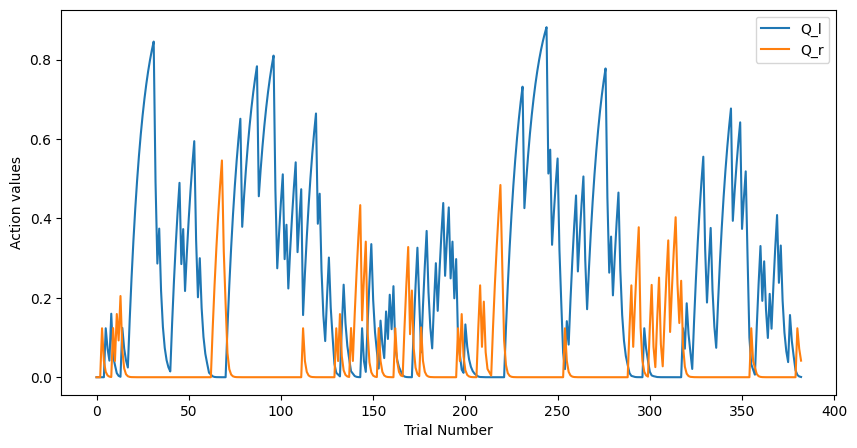

In [16]:
# plt.clf()
# fig = plt.figure(figsize=(10, 5))
# plt.plot(Q)
# plt.xlabel('Trial Number')
# plt.ylabel('Action values')
# plt.legend(['Q_l', 'Q_r'])
# name = f'{sessionFolder}/Qrl.svg'
# plt.savefig(name,format='svg')

In [13]:
# Q = fitRL['modelVars']['Q'][0][0][:,:]
# np.shape(Q)
# Qsum = np.sum(Q, axis=1)
# Qdiff = Q[:,1] - Q[:,0]

In [18]:
# plot all units
s = 6
fs = 14
fsLegend = 8
tb = -1
tf = 3
formula = 'spikes ~ 1 + outcomes + choices + laser + outcomes:laser + choices:laser'
cmap = plt.get_cmap('viridis')
for unitInd in range(len(unitIDs)):
    if unitInd%5==0:
        print('Neuron', unitIDs[unitInd])
    if qcPass[unitInd]:
        plt.clf()
        currArray = spike_toResponse.sel(unit_id = unitInd)
        currArrayLM = np.squeeze(tiled_dataLM[:,:,unitInd])
        currArrayBl = spike_toResponseBl.sel(unit_id = unitInd)
        currSpikes = timestampsRS[unitInd]
        fig = plt.figure(figsize=(30, 15))
        gs = gridspec.GridSpec(2, 5, width_ratios=[1,1,1,1,1], height_ratios=[4, 1])

        # from start to end
        ax = fig.add_subplot(gs[0, 0])  
        df = align.to_events(currSpikes, responseTimes, (tb, tf), return_df=True)
        ax.scatter(df.time, df.event_index, c='k', marker= '|', s=1)
        ax.set_xlim(tb, tf)
        ax.set_ylabel('Trial number', fontsize = fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        plt.plot([0,0],[0,df.event_index.max()],'r')
        plt.suptitle(f'Unit{str(unitIDs[unitInd])}', fontsize = 20)

        # waveform
        ax = fig.add_subplot(gs[1, 0])  
        waveform = units.loc[unitInd, 'waveform_mean']
        peakChannel = np.argmin(np.min(waveform, axis=0))
        peakWaveform = waveform[:,peakChannel]
        timeWF = np.array(range(len(peakWaveform)))-90
        ax.plot(timeWF, peakWaveform, color = 'k')
        ax.axhline(y=0, color = 'r', ls = '--')
        ax.set_xlabel('Time (ms)', fontsize = fs)
        ax.set_ylabel(r'$\mu$-Plot')

        # reward and no reward with laser
        indList = [list(np.where(np.logical_and(~outcomes, ~laserChoice))[0]),
                    list(np.where(np.logical_and(~outcomes, laserChoice))[0]),
                    list(np.where(np.logical_and(outcomes, ~laserChoice))[0]),
                    list(np.where(np.logical_and(outcomes, laserChoice))[0])]
        legendList = ['noRewardN', 'noRewardL', 'RewardN', 'RewawrdL']
        M0 = currArray.sel(trialInd = indList[0]).mean(dim='trialInd')
        M1 = currArray.sel(trialInd = indList[1]).mean(dim='trialInd')
        M2 = currArray.sel(trialInd = indList[2]).mean(dim='trialInd')
        M3 = currArray.sel(trialInd = indList[3]).mean(dim='trialInd')
        ax = fig.add_subplot(gs[1, 1])      
        ax.plot(time, M0, color = 'r',  ls = '-', label = legendList[0])
        ax.plot(time, M1, color = 'r', ls = '--', label = legendList[1])
        ax.plot(time, M2, color = 'b', ls = '-', label = legendList[2])
        ax.plot(time, M3, color = 'b', ls = '--', label = legendList[3])
        ax.axvline(x=0, ymin=0, ymax=200,   ls = '--', color = 'gray') 
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.set_xlim([tb, tf])
        ax.legend(fontsize=fs)
        ax.set_xlabel('Time from response (s)', fontsize=fs)

        currAlignTimes = np.concatenate((responseTimes[indList[0]], responseTimes[indList[1]],
                                        responseTimes[indList[2]], responseTimes[indList[3]]))
        df = align.to_events(currSpikes, currAlignTimes, (-2, 4), return_df=True)
        ax = fig.add_subplot(gs[0, 1])  # Subplot in the top-left corner
        ax.scatter(df.time, df.event_index, c='k', marker= '|', s=3)
        ax.set_xlim(tb, tf)
        plt.axvline(x = 0, color ='r')
        plt.axhline(y = (len(indList[0])+len(indList[1])), color='r', ls = '--')
        plt.axhline(y = (len(indList[0])), color='b', ls = '--')
        plt.axhline(y = len(indList[0])+len(indList[1])+len(indList[2]), color='b', ls = '--')
        legendList = ['leftN', 'leftL', 'rightN', 'rightL']
        label = '  '.join(legendList)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        # ax.set_yticks([])
        ax.set_ylabel(label, fontsize = fs)

        # left and right with laser
        indList = [list(np.where(np.logical_and(~choices, ~laserChoice))[0]),
                    list(np.where(np.logical_and(~choices, laserChoice))[0]),
                    list(np.where(np.logical_and(choices, ~laserChoice))[0]),
                    list(np.where(np.logical_and(choices, laserChoice))[0])]
        legendList = ['leftN', 'leftL', 'rightN', 'rightL']
        M0 = currArray.sel(trialInd = indList[0]).mean(dim='trialInd')
        M1 = currArray.sel(trialInd = indList[1]).mean(dim='trialInd')
        M2 = currArray.sel(trialInd = indList[2]).mean(dim='trialInd')
        M3 = currArray.sel(trialInd = indList[3]).mean(dim='trialInd')
        ax = fig.add_subplot(gs[1, 2])      
        ax.plot(time, M0, color = 'r',  ls = '-', label = legendList[0])
        ax.plot(time, M1, color = 'r', ls = '--', label = legendList[1])
        ax.plot(time, M2, color = 'b', ls = '-', label = legendList[2])
        ax.plot(time, M3, color = 'b', ls = '--', label = legendList[3])
        ax.axvline(x=0, ymin=0, ymax=200,   ls = '--', color = 'gray')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.set_xlim([tb, tf])
        ax.legend(fontsize=fs)
        ax.set_xlabel('Time from response (s)', fontsize=fs)

        currAlignTimes = np.concatenate((responseTimes[indList[0]], responseTimes[indList[1]],
                                        responseTimes[indList[2]], responseTimes[indList[3]]))
        df = align.to_events(currSpikes, currAlignTimes, (-2, 4), return_df=True)
        ax = fig.add_subplot(gs[0, 2])  # Subplot in the top-left corner
        ax.scatter(df.time, df.event_index, c='k', marker= '|', s=1)
        ax.set_xlim(tb, tf)
        plt.axvline(x = 0, color ='r')
        plt.axhline(y = (len(indList[0])+len(indList[1])), color='r', ls = '--')
        plt.axhline(y = (len(indList[0])), color='b', ls = '--')
        plt.axhline(y = len(indList[0])+len(indList[1])+len(indList[2]), color='b', ls = '--')
        # plt.plot([-1,3],[len(indList[0]+len(indList[1])), np.sum(~outcomes)],'r', ls='--')
        # plt.plot([-1,3],[np.sum(~outcomes)+np.sum(outcomes & ~laserChoice), np.sum(~outcomes)+np.sum(outcomes & ~laserChoice)],'b', ls='--')
        # plt.plot([-1,3],[np.sum(~outcomes & ~laserChoice), np.sum(~outcomes & ~laserChoice)],'b', ls='--')
        legendList = ['leftN', 'leftL', 'rightN', 'rightL']
        label = '  '.join(legendList)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        # ax.set_yticks([])
        ax.set_ylabel(label, fontsize = fs)
        gs = gridspec.GridSpec(3, 2, width_ratios=[3,2], height_ratios=[1, 1, 1])
        ax = fig.add_subplot(gs[1,1])
        
        # plot regresssions
        regressors, TvCurrU, PvCurrU, EvCurrU = myFunctions.fitSpikeModelP(trialData, currArrayLM, formula)
        TvCurrUSig = TvCurrU.copy()
        TvCurrUSig[PvCurrU>=0.05] = np.nan
        colors = cmap(np.linspace(0, 1, len(regressors)))
        for regress in range(1, len(regressors)):
            ax.plot(timeLM, TvCurrU[:, regress], lw = 1, color = colors[regress,], label = regressors[regress])
            ax.plot(timeLM, TvCurrUSig[:, regress], lw = 3, color = colors[regress,])
        ax.legend(fontsize = fsLegend)
        ax.set_xlabel('Time from response (s)', fontsize = fs)
        ax.set_title('T-stats', fontsize = fs)

        ax = fig.add_subplot(gs[0,1])
        for regress in range(1, len(regressors)):
            ax.plot(timeLM, -np.log10(PvCurrU[:, regress]), lw = 1, color = colors[regress,], label = regressors[regress])

        plt.axhline(y = -np.log10(0.05), color='r', ls = '--')
        ax.legend(fontsize = fsLegend)
        ax.set_xlabel('Time from response (s)', fontsize = fs)
        ax.set_title('p-value', fontsize = fs)
        
        # baseline 
        gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 1,1], height_ratios=[1, 1, 1])
        ax = fig.add_subplot(gs[2,3])
        numBins = 3
        rInd = np.argsort(trialData['Qr'])
        M = []
        for b in range(numBins):
            currM = currArrayBl.sel(trialInd = rInd[int(np.round(b*len(rInd)/numBins)): int(np.round((b+1)*len(rInd)/numBins))].values).mean(dim='trialInd')
            M.append(currM)

        cmap = plt.get_cmap('coolwarm')
        colors = cmap(np.linspace(0.6, 1, len(M)))
        for b in range(numBins):
            ax.plot(timeBl, M[b].values, c = colors[b,:])

        ax.set_title('Qr')

        ax = fig.add_subplot(gs[2, 4])
        numBins = 3
        rInd = np.argsort(trialData['Ql'])
        M = []
        for b in range(numBins):
            currM = currArrayBl.sel(trialInd = rInd[int(np.round(b*len(rInd)/numBins)): int(np.round((b+1)*len(rInd)/numBins))].values).mean(dim='trialInd')
            M.append(currM)

        cmap = plt.get_cmap('coolwarm')
        colors = cmap(np.linspace(0.6, 1, len(M)))
        for b in range(numBins):
            ax.plot(timeBl, M[b].values, c = colors[b,:])

        ax.set_title('Ql')

        name = f'{xarrayFolder}/unit{str(unitIDs[unitInd])}_xarray.pdf'
        plt.savefig(name)
        plt.close()

merge_pdfs(xarrayFolder, f'{sessionFolder}/combinedXarray.pdf')


Neuron 0.0
Neuron 6.0
Neuron 12.0
Neuron 19.0
Neuron 25.0
Neuron 30.0
Neuron 36.0
Neuron 42.0
Neuron 48.0
Neuron 53.0
Neuron 60.0
Neuron 65.0
Neuron 70.0
Neuron 76.0
Neuron 81.0
Neuron 86.0
Neuron 91.0
Neuron 97.0
Neuron 102.0
Neuron 107.0
Neuron 112.0
Neuron 117.0
Neuron 122.0
Neuron 127.0
Neuron 132.0
Neuron 137.0
Neuron 142.0
Neuron 147.0
Neuron 153.0
Neuron 158.0
Neuron 163.0
Neuron 168.0
Neuron 174.0
Neuron 179.0
Neuron 185.0
Neuron 190.0
Neuron 195.0
Neuron 201.0
Neuron 207.0
Neuron 214.0
Neuron 221.0
Neuron 227.0
Neuron 232.0
Neuron 240.0
Neuron 246.0
Neuron 251.0
Neuron 259.0
Neuron 266.0
Neuron 272.0
Neuron 277.0
Neuron 282.0
Neuron 289.0
Neuron 295.0
Neuron 301.0
Neuron 308.0
Neuron 316.0
Neuron 331.0
Neuron 351.0
Neuron 356.0
Neuron 361.0
Neuron 367.0
Neuron 374.0
Neuron 379.0
Neuron 384.0
Neuron 389.0
Neuron 394.0
Neuron 399.0
Neuron 404.0
Neuron 411.0
Neuron 416.0
Neuron 421.0
Neuron 426.0
Neuron 431.0
Neuron 437.0
Neuron 443.0
Neuron 448.0
Neuron 453.0
Neuron 458.0
Neuron

<Figure size 640x480 with 0 Axes>

In [100]:
merge_pdfs(xarrayFolder, f'{sessionFolder}/combinedXarray.pdf')
# delete_files_without_name(xarrayFolder, 'combined')

Merging file 0 out of 262
Merging file 50 out of 262
Merging file 100 out of 262
Merging file 150 out of 262
Merging file 200 out of 262
Merging file 250 out of 262
PDF files in '/root/capsule/results/689514_2024-02-01_18-06-43/xarray' merged into '/root/capsule/results/689514_2024-02-01_18-06-43/combinedXarray.pdf' successfully.


In [23]:
# summary of all neurons by LM
# data preparation for LM
alignTime = trialStarts
bin_edgesSum = np.array([-2, 0, 1]).astype(float)
binSizeSum = 1
domain = myFunctions.build_time_window_domain(
    bin_edgesSum,
    alignTime,
    callback=time_domain_callback)
dtype = None

timeSum, countsSum = myFunctions.build_spike_histogram_overlap(
    domain,
    binSizeSum,
    timestampsRS,
)
tiled_dataLM = countsSum
timeLM = timeSum[0,] - alignTime[0]

In [24]:
regressionName = 'baselineVScue'
s = 6
fs = 14
fsLegend = 8
tb = -1
tf = 3
formula = 'spikes ~ 1 + choices + Qr + Ql'
tvAll = np.array([])
pvAll = np.array([])
cmap = plt.get_cmap('viridis')
for unitInd in range(len(unitIDs)):
    if unitInd%5==0:
        print('Neuron', unitIDs[unitInd])
    if qcPass[unitInd]:
        currArrayLM = np.squeeze(tiled_dataLM[trialData['laser']==0,:,unitInd])
        regressors, TvCurrU, PvCurrU, EvCurrU = myFunctions.fitSpikeModelP(trialData[trialData['laser']==0], currArrayLM, formula)
        if np.shape(tvAll)[0]==0:
            tvAll = np.empty((len(timeLM), len(regressors), 0))
            pvAll = np.empty((len(timeLM), len(regressors), 0))

        tvAll = np.concatenate((tvAll, TvCurrU[:, :, np.newaxis]), axis = 2)
        pvAll = np.concatenate((pvAll, PvCurrU[:, :, np.newaxis]), axis = 2)

Neuron 0.0
Neuron 6.0
Neuron 12.0
Neuron 19.0
Neuron 25.0
Neuron 30.0
Neuron 36.0
Neuron 42.0
Neuron 48.0
Neuron 53.0
Neuron 60.0
Neuron 65.0
Neuron 70.0
Neuron 76.0
Neuron 81.0
Neuron 86.0
Neuron 91.0
Neuron 97.0
Neuron 102.0
Neuron 107.0
Neuron 112.0
Neuron 117.0
Neuron 122.0
Neuron 127.0
Neuron 132.0
Neuron 137.0
Neuron 142.0
Neuron 147.0
Neuron 153.0
Neuron 158.0
Neuron 163.0
Neuron 168.0
Neuron 174.0
Neuron 179.0
Neuron 185.0
Neuron 190.0
Neuron 195.0
Neuron 201.0
Neuron 207.0
Neuron 214.0
Neuron 221.0
Neuron 227.0
Neuron 232.0
Neuron 240.0
Neuron 246.0
Neuron 251.0
Neuron 259.0
Neuron 266.0
Neuron 272.0
Neuron 277.0
Neuron 282.0
Neuron 289.0
Neuron 295.0
Neuron 301.0
Neuron 308.0
Neuron 316.0
Neuron 331.0
Neuron 351.0
Neuron 356.0
Neuron 361.0
Neuron 367.0
Neuron 374.0
Neuron 379.0
Neuron 384.0
Neuron 389.0
Neuron 394.0
Neuron 399.0
Neuron 404.0
Neuron 411.0
Neuron 416.0
Neuron 421.0
Neuron 426.0
Neuron 431.0
Neuron 437.0
Neuron 443.0
Neuron 448.0
Neuron 453.0
Neuron 458.0
Neuron

In [15]:
np.savez(f'{sessionFolder}/{regressionName}', tvAllA = tvAll, pvAllA = pvAll)
with open(f'{sessionFolder}/{regressionName}.txt', 'w') as file:
    for string in regressors:
        file.write(f'{string}\n')

In [25]:
timeBin = 0
baselineTs = np.squeeze(tvAll[timeBin,:,:])
baselineQs = np.squeeze(pvAll[timeBin,:,:])

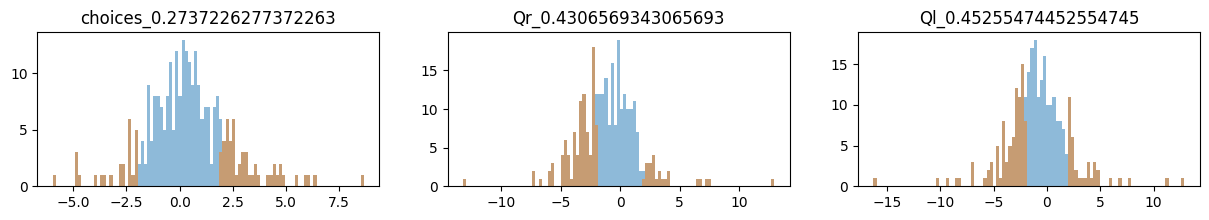

In [26]:
fig = plt.figure(figsize=(15, 2))
gs = gridspec.GridSpec(1, len(regressors)-1, width_ratios=np.ones((1, len(regressors)-1)).tolist()[0], height_ratios=[1])
# from start to end
for i, regresser in enumerate(regressors):
    if i > 0:
        ax = fig.add_subplot(gs[i-1])
        edge = np.linspace(np.min(baselineTs[i,])-0.001, np.max(baselineTs[i,])+0.001, 100)
        ax.hist(np.squeeze(baselineTs[i,]), alpha=0.5, bins = edge)
        ax.hist(np.squeeze(baselineTs[i,np.squeeze(baselineQs[i,]<0.05)]), alpha=0.5, bins = edge)
        ax.set_title(f'{regresser}_{np.mean(baselineQs[i,]<0.05)}')
plt.savefig(f'{sessionFolder}/allRegHistBariQonly.svg', format='svg')

In [27]:
# generate groupIDs
# 1 is diff+, 2 for diff-, 3 for sum+, 4 for sum-
baselineTs = np.squeeze(tvAll[timeBin,:,:])
baselineQs = np.squeeze(pvAll[timeBin,:,:])
sigsMat = (baselineQs<0.05) * np.sign(baselineTs)
sigsMat = sigsMat.T
id = np.zeros((np.shape(baselineTs)[1], 1))
id[(sigsMat[:, np.array(regressors)=='Qr'] ==1) & (sigsMat[:, np.array(regressors)=='Ql'] ==0)] = 1
id[(sigsMat[:, np.array(regressors)=='Qr'] ==-1) & (sigsMat[:, np.array(regressors)=='Ql'] ==0)] = 2
id[(sigsMat[:, np.array(regressors)=='Qr'] ==0) & (sigsMat[:, np.array(regressors)=='Ql'] ==1)] = 3
id[(sigsMat[:, np.array(regressors)=='Qr'] ==-0) & (sigsMat[:, np.array(regressors)=='Ql'] ==-1)] = 4

In [28]:
timeBin = 0
baselineTs = np.squeeze(tvAll[timeBin,:,:])
baselineQs = np.squeeze(pvAll[timeBin,:,:])
sigs = baselineQs<0.05
sigs = np.max(sigs[-2:,].astype(float), axis=0)
# sign = np.sign(baselineTs[-2:,].flatten())
# sigs = sigs*sign
np.mean(np.abs(sigs))

0.5875912408759124

In [29]:
# sigs = baselineQs<0.05
# sigs =  np.max(sigs[-2:,].astype(float), axis=0)
dfTs = pd.DataFrame(baselineTs[1:,].T, columns=regressors[1:])
dfTs['sigs'] = sigs
dfTs['id'] = id

<Figure size 200x200 with 0 Axes>

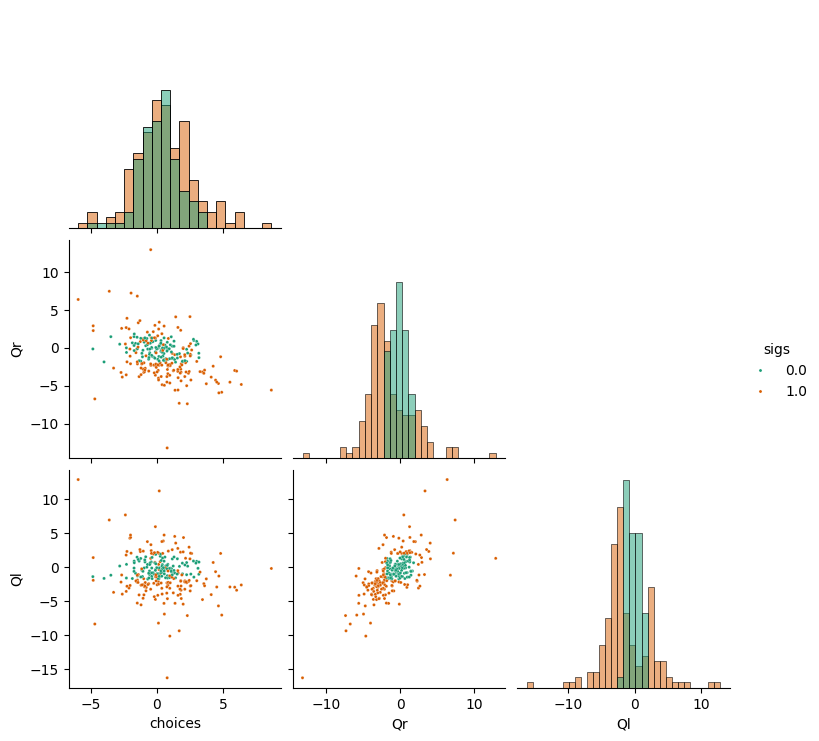

In [30]:
fig = plt.figure(figsize=(2, 2))
sns.pairplot(data=dfTs, vars = regressors[1:], corner=True, hue= 'sigs', diag_kind='hist', plot_kws={'s': 5}, palette='Dark2')
plt.savefig(f'{sessionFolder}/allRegBariOnlyDiffSum.svg', format='svg')

In [31]:
regressionName = 'update'
s = 6
fs = 14
fsLegend = 8
tb = -1
tf = 3
formula = 'spikes ~ 1 + choicesPrev*laserPrev*outcomePrev'
tvAllDiff = np.array([])
pvAllDiff = np.array([])
trialDataDiff = trialData.drop(0)
cmap = plt.get_cmap('Dark2')
for unitInd in range(len(unitIDs)):
    if unitInd%5==0:
        print('Neuron', unitIDs[unitInd])
    if qcPass[unitInd]:
        currArrayLM = np.diff(np.squeeze(tiled_dataLM[:,:,unitInd]), axis=0)
        regressorsDiff, TvCurrU, PvCurrU, EvCurrU = myFunctions.fitSpikeModelG(trialDataDiff, currArrayLM, formula)
        if np.shape(tvAllDiff)[0]==0:
            tvAllDiff = np.empty((len(timeLM), len(regressorsDiff), 0))
            pvAllDiff = np.empty((len(timeLM), len(regressorsDiff), 0))

        tvAllDiff = np.concatenate((tvAllDiff, TvCurrU[:, :, np.newaxis]), axis = 2)
        pvAllDiff = np.concatenate((pvAllDiff, PvCurrU[:, :, np.newaxis]), axis = 2)

Neuron 0.0
Neuron 6.0
Neuron 12.0
Neuron 19.0
Neuron 25.0
Neuron 30.0
Neuron 36.0
Neuron 42.0
Neuron 48.0
Neuron 53.0
Neuron 60.0
Neuron 65.0
Neuron 70.0
Neuron 76.0
Neuron 81.0
Neuron 86.0
Neuron 91.0
Neuron 97.0
Neuron 102.0
Neuron 107.0
Neuron 112.0
Neuron 117.0
Neuron 122.0
Neuron 127.0
Neuron 132.0
Neuron 137.0
Neuron 142.0
Neuron 147.0
Neuron 153.0
Neuron 158.0
Neuron 163.0
Neuron 168.0
Neuron 174.0
Neuron 179.0
Neuron 185.0
Neuron 190.0
Neuron 195.0
Neuron 201.0
Neuron 207.0
Neuron 214.0
Neuron 221.0
Neuron 227.0
Neuron 232.0
Neuron 240.0
Neuron 246.0
Neuron 251.0
Neuron 259.0
Neuron 266.0
Neuron 272.0
Neuron 277.0
Neuron 282.0
Neuron 289.0
Neuron 295.0
Neuron 301.0
Neuron 308.0
Neuron 316.0
Neuron 331.0
Neuron 351.0
Neuron 356.0
Neuron 361.0
Neuron 367.0
Neuron 374.0
Neuron 379.0
Neuron 384.0
Neuron 389.0
Neuron 394.0
Neuron 399.0
Neuron 404.0
Neuron 411.0
Neuron 416.0
Neuron 421.0
Neuron 426.0
Neuron 431.0
Neuron 437.0
Neuron 443.0
Neuron 448.0
Neuron 453.0
Neuron 458.0
Neuron

In [32]:
timeBin = 0
baselineTs = np.squeeze(tvAllDiff[timeBin,:,:])
baselineQs = np.squeeze(pvAllDiff[timeBin,:,:])

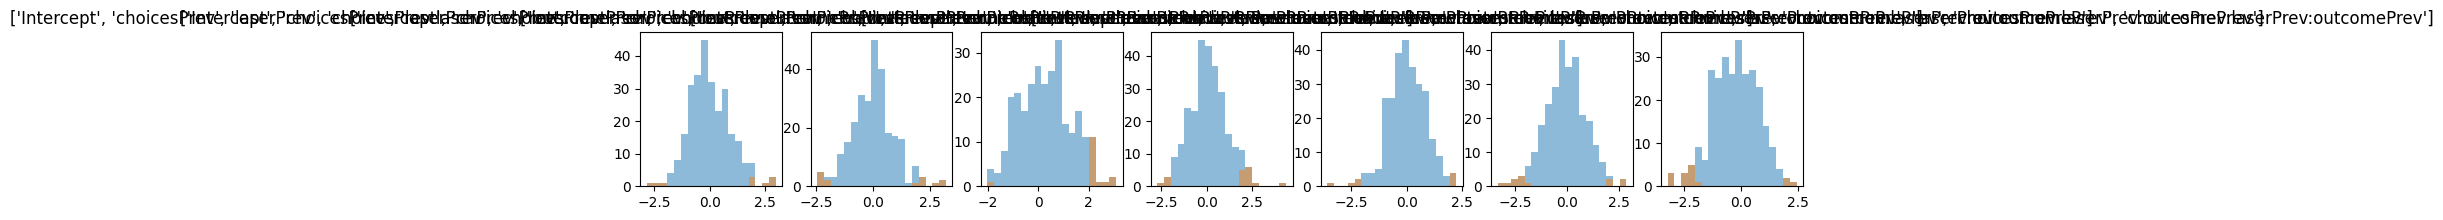

In [33]:
fig = plt.figure(figsize=(15, 2))
gs = gridspec.GridSpec(1, len(regressorsDiff)-1, width_ratios=np.ones((1, len(regressorsDiff)-1)).tolist()[0], height_ratios=[1])
# from start to end
for i, regresser in enumerate(regressorsDiff):
    if i > 0:
        ax = fig.add_subplot(gs[i-1])
        edge = np.linspace(np.min(baselineTs[i,])-0.001, np.max(baselineTs[i,])+0.001, 20)
        ax.hist(np.squeeze(baselineTs[i,]), alpha=0.5, bins = edge)
        ax.hist(np.squeeze(baselineTs[i,np.squeeze(baselineQs[i,]<0.05)]), alpha=0.5, bins = edge)
        ax.set_title(regressorsDiff)
plt.savefig(f'{sessionFolder}/diffallRegHistBariAllInterAndL.svg', format='svg')

In [34]:
# sigs = baselineQs<0.05
# sigs = np.max(sigs[-1:,].astype(float), axis=0)
# sign = np.sign(baselineTs[-1:,].flatten())
# sigs = sigs*sign
# sigs
dfTs = pd.DataFrame(baselineTs[1:,].T, columns=regressorsDiff[1:])
dfTs['sigs'] = sigs
dfTs['id'] = id

<Figure size 200x200 with 0 Axes>

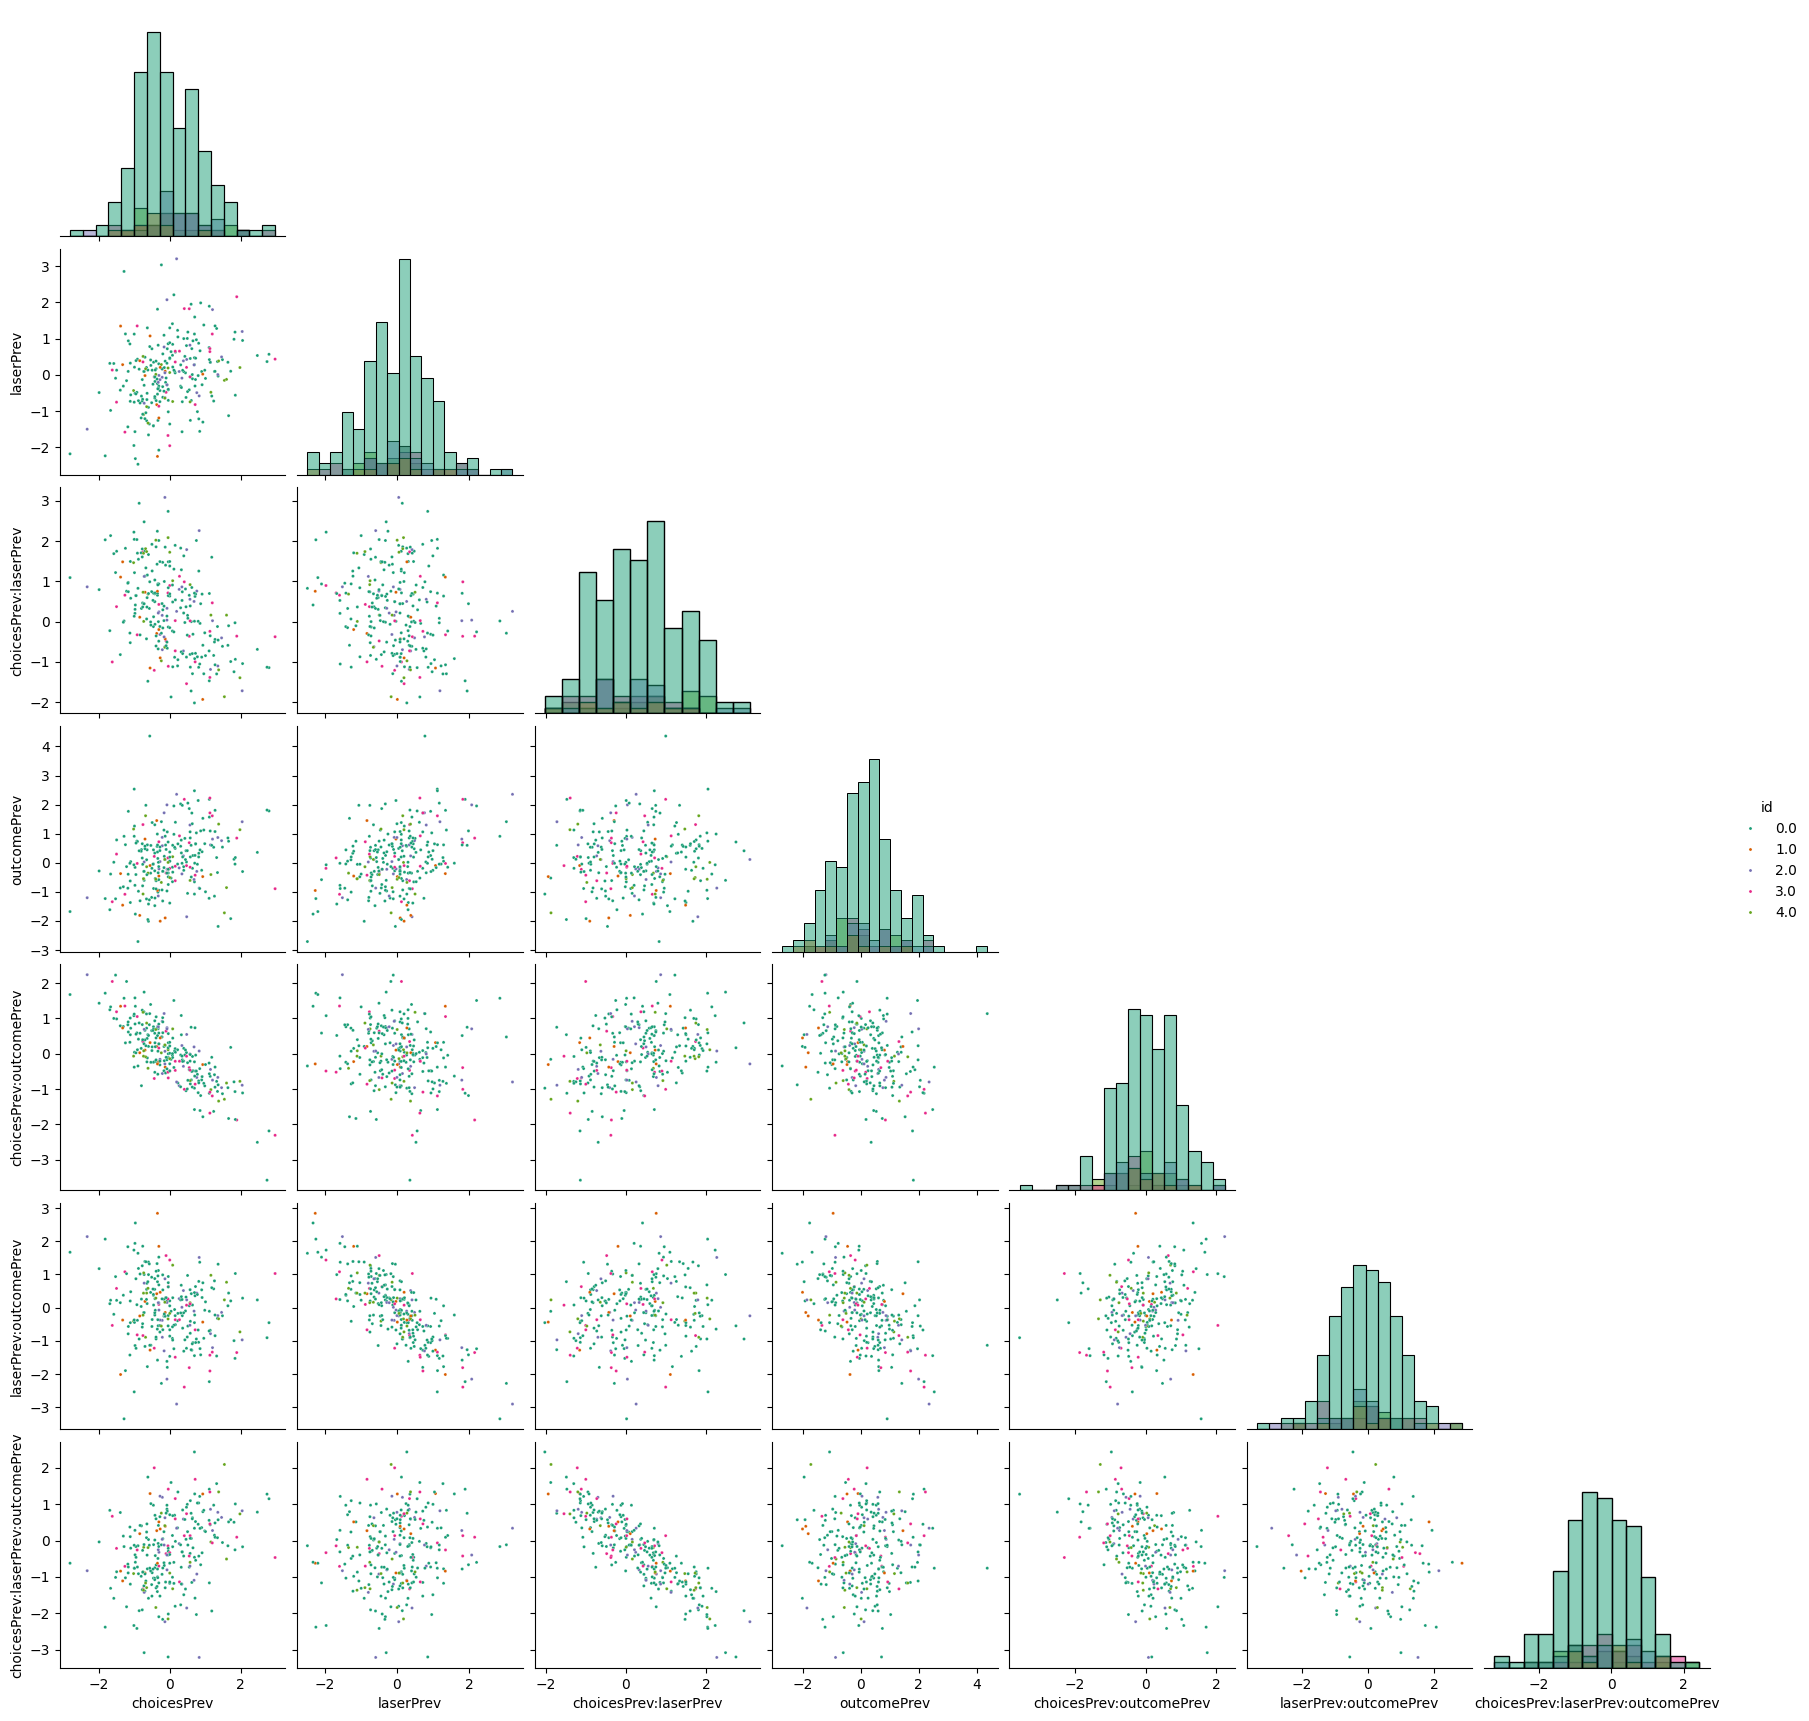

In [35]:
fig = plt.figure(figsize=(2, 2))
sns.pairplot(data=dfTs, vars = regressorsDiff[1:], corner=True, hue= 'id', diag_kind='hist', plot_kws={'s': 5}, palette='Dark2')
plt.savefig(f'{sessionFolder}/diffallRegPairQsumDiffLaserInteraction2BariAllInterAndQdiffInd.svg', format='svg')

In [127]:
np.shape(tile)

(383, 2, 544)

In [41]:
len(responseTimes)

383

In [37]:
# calculate neuron updates
allUpdates = np.empty((0, 8)) # laser by R/L by unit
trialDataDiff = trialData.drop(0)
cmap = plt.get_cmap('Dark2')
gName = ['R-rwd-laser', 'R-Nrwd-laser', 'L-rwd-laser', 'L-Nrwd-laser','R-rwd-No laser', 'R-Nrwd-No laser', 'L-rwd-No laser', 'L-Nrwd-No laser']
currInd = []
# R-rwd-laser
currInd.append((trialDataDiff['choicesPrev']>0) & (trialDataDiff['outcomePrev']>0) & (trialDataDiff['laserPrev']>0))
# R-Nrwd-laser
currInd.append((trialDataDiff['choicesPrev']>0) & (trialDataDiff['outcomePrev']==0) & (trialDataDiff['laserPrev']>0))
# L-rwd-laser)
currInd.append((trialDataDiff['choicesPrev']==0) & (trialDataDiff['outcomePrev']>0) & (trialDataDiff['laserPrev']>0))
# L-Nrwd-laser
currInd.append((trialDataDiff['choicesPrev']==0) & (trialDataDiff['outcomePrev']==0) & (trialDataDiff['laserPrev']>0))
# R-rwd-no laser
currInd.append((trialDataDiff['choicesPrev']>0) & (trialDataDiff['outcomePrev']>0) & (trialDataDiff['laserPrev']==0))
# R-Nrwd-no laser
currInd.append((trialDataDiff['choicesPrev']>0) & (trialDataDiff['outcomePrev']==0) & (trialDataDiff['laserPrev']==0))      
# L-rwd-no laser
currInd.append((trialDataDiff['choicesPrev']==0) & (trialDataDiff['outcomePrev']>0) & (trialDataDiff['laserPrev']==0))
# L-Nrwd-no laser
currInd.append((trialDataDiff['choicesPrev']==0) & (trialDataDiff['outcomePrev']==0) & (trialDataDiff['laserPrev']==0))
for unitInd in range(len(unitIDs)):
    if unitInd%5==0:
        print('Neuron', unitIDs[unitInd])
    if qcPass[unitInd]:
        tmpArray = np.full((1, 8), np.nan)
        currArrayLM = np.diff(np.squeeze(tiled_dataLM[:,1,unitInd]), axis=0)
        for condInd, condition in enumerate(gName):
            tmpArray[0,condInd] = np.mean(currArrayLM[currInd[condInd]])
        
        tmpArray = zscore(tmpArray,axis=1)
        allUpdates = np.concatenate((allUpdates, tmpArray))



Neuron 0.0
Neuron 6.0
Neuron 12.0
Neuron 19.0
Neuron 25.0
Neuron 30.0
Neuron 36.0
Neuron 42.0
Neuron 48.0
Neuron 53.0
Neuron 60.0
Neuron 65.0
Neuron 70.0
Neuron 76.0
Neuron 81.0
Neuron 86.0
Neuron 91.0
Neuron 97.0
Neuron 102.0
Neuron 107.0
Neuron 112.0
Neuron 117.0
Neuron 122.0
Neuron 127.0
Neuron 132.0
Neuron 137.0
Neuron 142.0
Neuron 147.0
Neuron 153.0
Neuron 158.0
Neuron 163.0
Neuron 168.0
Neuron 174.0
Neuron 179.0
Neuron 185.0
Neuron 190.0
Neuron 195.0
Neuron 201.0
Neuron 207.0
Neuron 214.0
Neuron 221.0
Neuron 227.0
Neuron 232.0
Neuron 240.0
Neuron 246.0
Neuron 251.0
Neuron 259.0
Neuron 266.0
Neuron 272.0
Neuron 277.0
Neuron 282.0
Neuron 289.0
Neuron 295.0
Neuron 301.0
Neuron 308.0
Neuron 316.0
Neuron 331.0
Neuron 351.0
Neuron 356.0
Neuron 361.0
Neuron 367.0
Neuron 374.0
Neuron 379.0
Neuron 384.0
Neuron 389.0
Neuron 394.0
Neuron 399.0
Neuron 404.0
Neuron 411.0
Neuron 416.0
Neuron 421.0
Neuron 426.0
Neuron 431.0
Neuron 437.0
Neuron 443.0
Neuron 448.0
Neuron 453.0
Neuron 458.0
Neuron

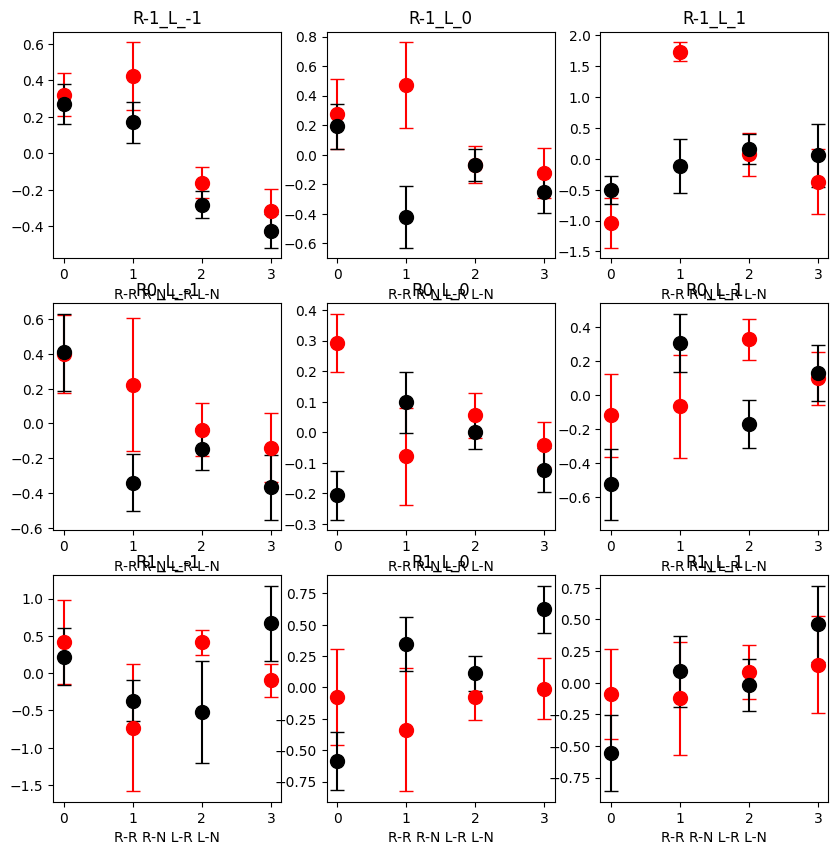

In [43]:
DiffSigs = [-1, 0, 1]
SumSigs = [-1, 0, 1]
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(len(SumSigs), len(DiffSigs), width_ratios=np.ones((1, len(DiffSigs))).tolist()[0], height_ratios=np.ones((1, len(DiffSigs))).tolist()[0])

# from start to end
x = np.array(range(4))
plt.clf()
for i, dSig in enumerate(DiffSigs): 
    for j, sSig in enumerate(SumSigs):
        currUnits = (sigsMat[:, np.array(regressors)=='Qr'] == dSig) & (sigsMat[:, np.array(regressors)=='Ql'] == sSig)
        currPop = allUpdates[np.squeeze(currUnits),:]
        ax = fig.add_subplot(gs[i, j])
        popMean = np.mean(currPop, axis=0)
        popSem = np.std(currPop, axis=0)/np.sqrt(np.shape(currPop)[0])
        ax.errorbar(x, popMean[0:4], yerr=popSem[0:4], linestyle='', color='r', markersize=10, fmt='o', capsize=5)
        ax.errorbar(x, popMean[4:], yerr=popSem[4:], linestyle='', color='k', markersize=10, fmt='o', capsize=5)
        ax.set_title(f'R{dSig}_L_{sSig}')
        ax.set_xlabel('R-R R-N L-R L-N')

name = f'{sessionFolder}/QrlUpdate.svg'
plt.savefig(name,format='svg')

In [81]:
 currPop = allUpdates[np.squeeze(currUnits),:]

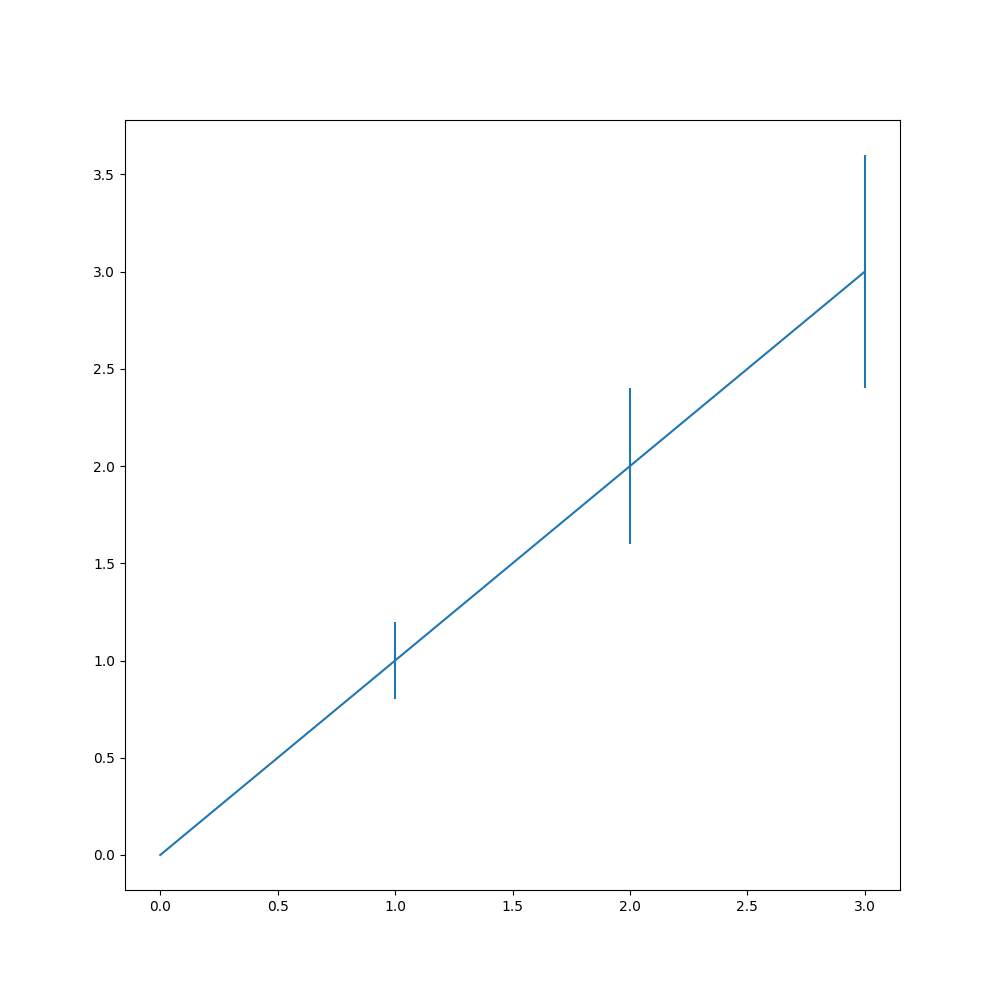

In [212]:
plt.clf()
plt.errorbar(np.array(range(4)), np.array(range(4)), yerr = 0.2*np.array(range(4)))
plt.show()

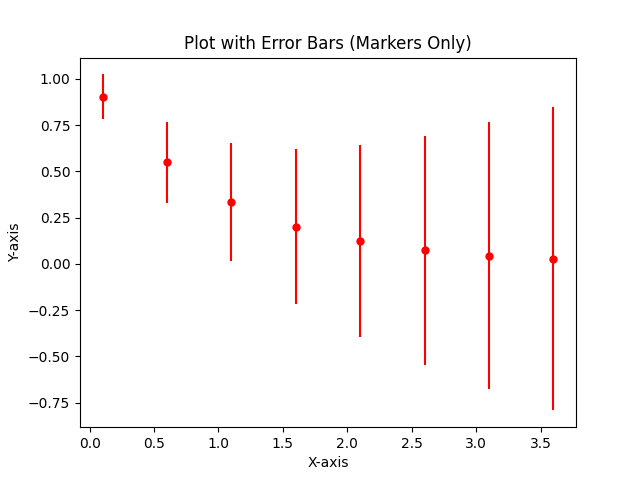

In [210]:
import matplotlib.pyplot as plt
import numpy as np

# Create some example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)
errors = 0.1 + 0.2 * x

# Create a figure and axis
fig, ax = plt.subplots()

# Plot with error bars without lines
ax.errorbar(x, y, yerr=errors, fmt='o', linestyle='', color='red', markersize=5)

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Plot with Error Bars (Markers Only)')

# Show the plot
plt.show()


In [196]:
dSig = 1
currPop = allUpdates[diffsigs==dSig,:]
popMean = np.mean(currPop, axis=0)
popSem = np.std(currPop, axis=0)/np.sqrt(np.shape(currPop)[0])
allUpdates.shape

array([ 1.15366086, -1.66440392,  1.25166885, -1.05203333, -0.32935395,
        1.01334413, -0.28772332, -0.08515932])

In [136]:
allUpdates = np.empty((0, 8)) # laser by R/L by unit
trialDataDiff = trialData.drop(0)
cmap = plt.get_cmap('Dark2')



In [140]:
trialDataDiff[currInd[3]]

,outcomes,choices,laser,outcomePrev,laserPrev,choicesPrev,Qsum,Qdiff,Qr,Ql
7,1.0,0.0,0.0,0.0,1.0,0.0,0.043245,-0.040295,1.475155e-03,0.041770
15,0.0,0.0,0.0,0.0,1.0,0.0,0.094713,-0.049970,2.237168e-02,0.072341
32,0.0,0.0,0.0,0.0,1.0,0.0,0.492054,-0.492054,1.514454e-10,0.492054
37,0.0,0.0,1.0,0.0,1.0,0.0,0.073793,-0.073793,5.990719e-13,0.073793
38,0.0,0.0,0.0,0.0,1.0,0.0,0.042946,-0.042946,1.981178e-13,0.042946
54,0.0,0.0,0.0,0.0,1.0,0.0,0.346060,-0.346060,4.055426e-21,0.346060
57,0.0,0.0,1.0,0.0,1.0,0.0,0.174526,-0.174526,1.466797e-22,0.174526
58,0.0,0.0,1.0,0.0,1.0,0.0,0.101570,-0.101570,4.850815e-23,0.101570
59,0.0,0.0,0.0,0.0,1.0,0.0,0.059111,-0.059111,1.604203e-23,0.059111
123,0.0,0.0,1.0,0.0,1.0,0.0,0.156572,-0.156570,6.381894e-07,0.156571


In [ ]:

# R-Nrwd-laser
currInd[1] = (trialDataDiff['choicesPrev']>0) & (trialDataDiff['outcomePrev']==0) & (trialDataDiff['laserPrev']>0)
# L-rwd-laser
currInd[2] = (trialDataDiff['choicesPrev']==0) & (trialDataDiff['outcomePrev']>0) & (trialDataDiff['laserPrev']>0)
# L-Nrwd-laser
currInd[3] = (trialDataDiff['choicesPrev']==0) & (trialDataDiff['outcomePrev']==0) & (trialDataDiff['laserPrev']>0)
# R-rwd-no laser
currInd[4] = (trialDataDiff['choicesPrev']>0) & (trialDataDiff['outcomePrev']>0) & (trialDataDiff['laserPrev']==0)
# R-Nrwd-no laser
currInd[5] = (trialDataDiff['choicesPrev']>0) & (trialDataDiff['outcomePrev']==0) & (trialDataDiff['laserPrev']==0)      
# L-rwd-no laser
currInd[6] = (trialDataDiff['choicesPrev']==0) & (trialDataDiff['outcomePrev']>0) & (trialDataDiff['laserPrev']==0)
# L-Nrwd-no laser
currInd[7] = (trialDataDiff['choicesPrev']==0) & (trialDataDiff['outcomePrev']==0) & (trialDataDiff['laserPrev']==0)
